## 0. Imports

In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

## 1. Exploring Deravitives

4.0


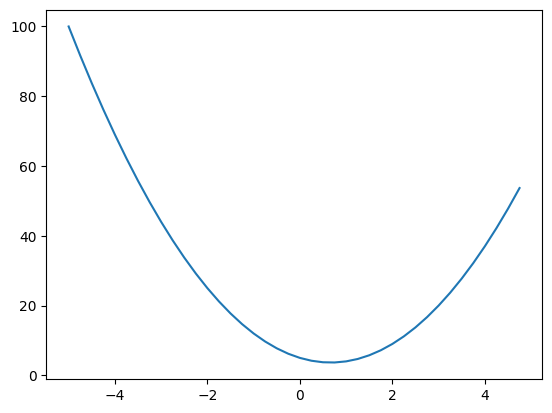

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

f(3.0)
20.0
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

h = 0.000001
x = 2/3
(f(x + h) - f(x))/h
2.999378523327323e-06
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

## 2. Defining a Value Class
A class that will keep track of the changes made to a variable and the operations it undergoes inorder to enable backpropegation.

In [3]:
class Value:
  """
      A class of values.
      """

  def __init__(self, data, _children=(), _op='', label=''):
    """
        :param data: The numeric value of the object.
        :param _children: The children of the value.
        :param _op: The operation that produced the value in a list of characters as a string.
        :param label: The label of the value.
        :return: An instance of value.
        :rtype: Value
        """
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    """
        :param other: Another value.
        :return: The product of the two values.
        :rtype: Value
        """

    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out
  
  def new_activation(self):
    x = self.data
    
    if (x > 2):
      x = 2
    elif (x < -2):
      x = -2

    out =  Value(x, (self, ), 'lin')

    def _backward():
      self.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

## 3. Visualization
Defining a few functions to help visualizing the operations and the pedegree of Value objects created.

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


### 3.1 Testing Visualization

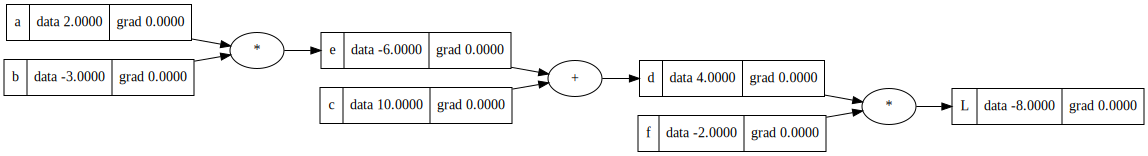

In [5]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L
draw_dot(L)

## 4. Manual Backpropogation

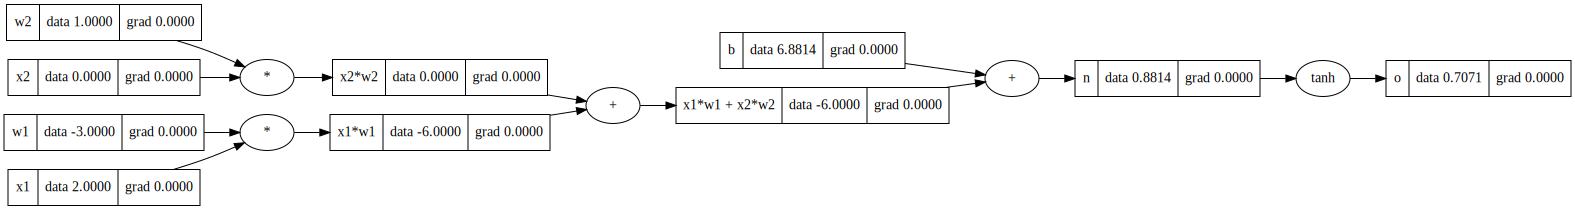

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

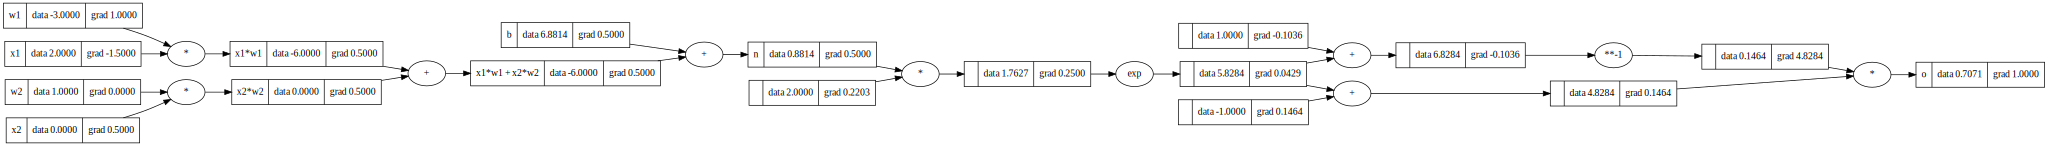

In [9]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

## 5. Pytorch

In [5]:
import torch

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## 6. Neural Net Library

In [4]:
class Neuron:
  """
      Class of Neuron objects
        - the number of inputs is fixed at initialization
        - the weights and bias are initialized randomly
        - the activation function is tanh
      """

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.new_activation()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [15]:
x = [2.0]
n = MLP(1,[1])
n(x)

Value(data=0.5118781508221497)

## 7. Training a Neural Net


### 7.1 Initializing a Data Set (Input and Labels)

In [6]:
xs = [[2], [3], [4]]
ys = [2, 1, -2]


### 7.2 Training with Data Set

In [16]:
losses = []
weights = []
biases = []

for k in range(400):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.06 * p.grad

  print(k, loss.data)

  losses.append(loss.data)
  weights.append(n.layers[0].neurons[0].w[0].data)
  biases.append(n.layers[0].neurons[0].b.data)


0 14.765709791019944
1 25
2 17
3 25
4 17
5 25
6 17.000017907389292
7 25
8 17.058415353950778
9 25
10 17.043786940791293
11 25
12 16.493809243723923
13 25
14 16.734100250070192
15 25
16 13.811107422788329
17 25
18 17
19 25
20 13.760134216608497
21 25
22 16.47910295862895
23 25
24 11.815740417580788
25 25
26 17
27 25
28 13.849466960694398
29 25
30 14.778944533015467
31 25
32 13.812962895847992
33 23.504949437137725
34 13.323740695654125
35 22.211586551411372
36 12.523426403569138
37 20.83426392476307
38 11.92237894443611
39 19.662399861646655
40 11.300642049994547
41 18.562637527073647
42 10.746258272447067
43 17.576653158444607
44 10.217927267403569
45 16.675278058866038
46 9.729161464061296
47 15.859414306970022
48 9.270663767486203
49 15.118526833920576
50 8.843022272309728
51 14.44759826976551
52 8.442903662073952
53 13.840112909069369
54 8.068858065968815
55 13.290868955424738
56 7.718852095811121
57 12.794771643014592
58 7.391294127497728
59 12.347274826976388
60 7.084586459612103


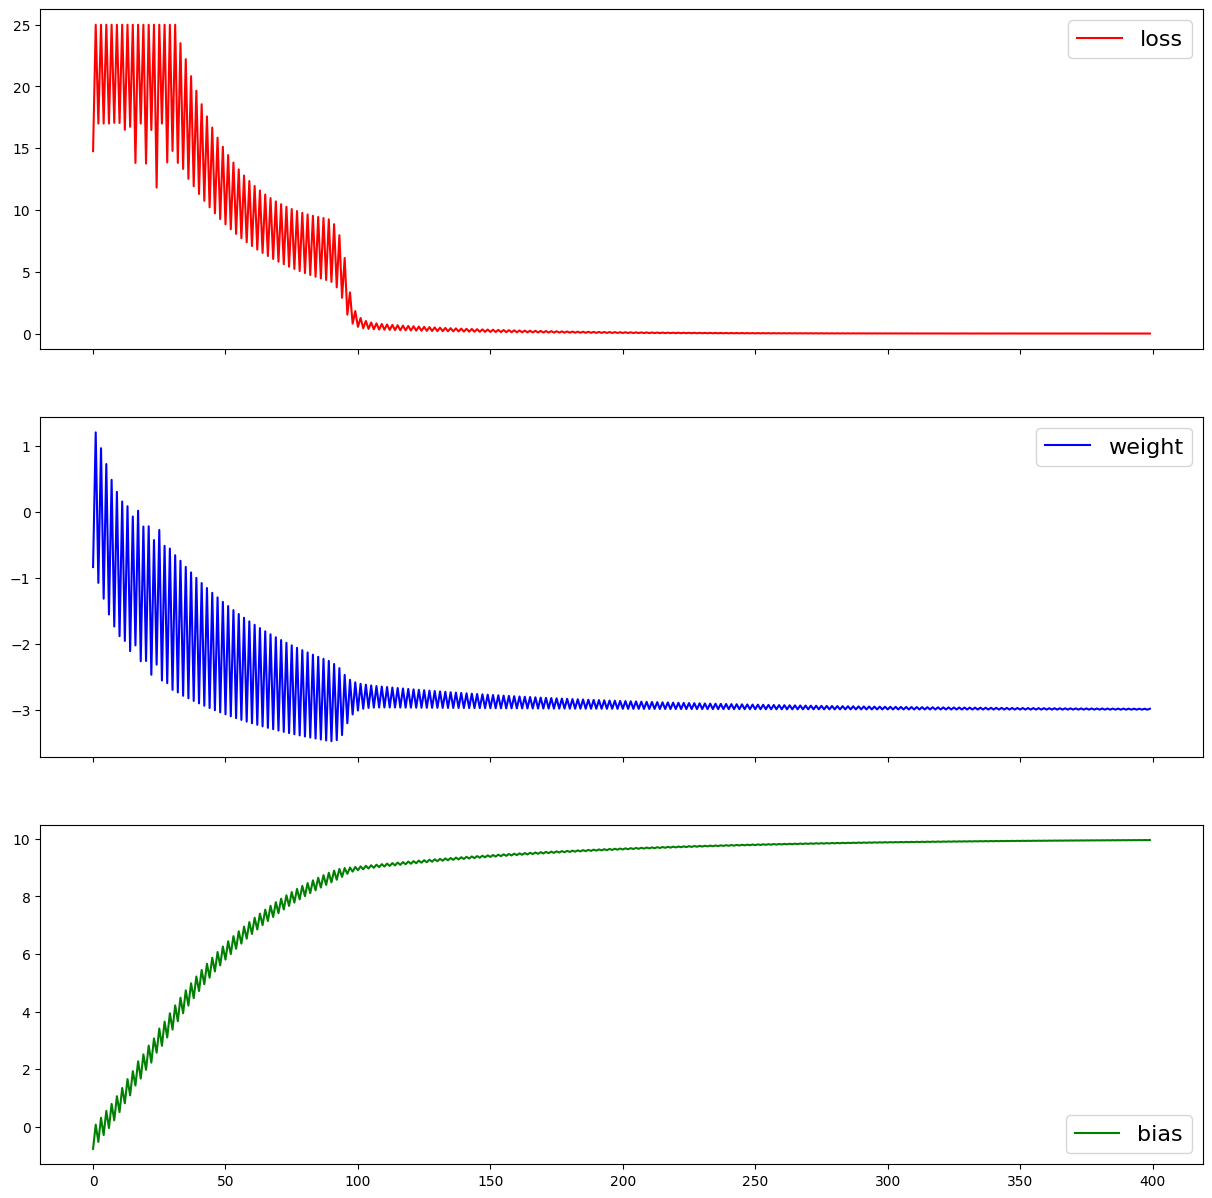

In [29]:
from matplotlib.pyplot import xlabel


fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

axs[0].plot(losses, label='loss', color='red')
axs[1].plot(weights, label='weight', color='blue')
axs[2].plot(biases, label='bias', color='green')
axs[0].legend(loc='upper right', fontsize=16)
axs[1].legend(loc='upper right', fontsize=16)
axs[2].legend(loc='lower right', fontsize=16)
